<a href="https://colab.research.google.com/github/jb1521/ReinforcementLearningforBioengineers/blob/main/RLfB_cw2_sac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [24]:
!pip install gymnasium[classic-control]
!pip install -q mujoco
!pip install -q mujoco-py

import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import collections, random

Hyperparameters

In [2]:
lr_pi           = 0.0005 # policy learning rate
lr_q            = 0.001 # Q-function learning rate
init_alpha      = 0.01 # trade-off coefficient
gamma           = 0.98 # discount factor
batch_size      = 32
buffer_limit    = 50000
tau             = 0.01 # for target network soft update
target_entropy  = -1.0 # for automated alpha update
lr_alpha        = 0.001  # for automated alpha update

Replay Buffer

In [3]:
class ReplayBuffer():
    # initialising a double-ended queue to establish the replay buffer
    def __init__(self):
      self.buffer = collections.deque(maxlen=buffer_limit)

    def size(self):
        return len(self.buffer)

    # appending a transition to the replay buffer
    def put(self, transition):
      self.buffer.append(transition)

    # taking a random sample (size n) from the replay buffer to train the model
    def sample(self, n):
      mini_batch = random.sample(self.buffer, n) # batch from replay buffer
      s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], [] # lists for items in batch

      # adding items of a transition to respective list
      for transition in mini_batch:
        s, a, r, s_prime, done = transition
        s_lst.append(s)
        a_lst.append([a])
        r_lst.append([r])
        s_prime_lst.append(s_prime)
        done_mask = 0.0 if done else 1.0
        done_mask_lst.append([done_mask])

      # returing the lists as tensors
      return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)

Policy Network

In [4]:
class PolicyNet(nn.Module):
    # initialises a neural network from nn.Module
    def __init__(self, learning_rate):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(4, 128) # fully-connected layer, with 3 input neurons and 128 output neurons
        self.fc_mu = nn.Linear(128,1) # mean averaging, 128 inputs give one scalar
        self.fc_std  = nn.Linear(128,1) # standard deviation, 128 inputs give one scalar
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate) # optimise parameters of the model

        self.log_alpha = torch.tensor(np.log(init_alpha)) # logarithm of entropy regularisation factor
        self.log_alpha.requires_grad = True # enables gradient of log_alpha
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=lr_alpha) # optimise log_alpha through training

    # forward pass of neural network
    def forward(self, x):
        x = F.relu(self.fc1(x)) # input processing
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std) # action distribution
        action = dist.rsample() # action sampling
        log_prob = dist.log_prob(action)
        real_action = torch.tanh(action) # action transformation, limits between [-1,1]
        real_log_prob = log_prob - torch.log(1-torch.tanh(action).pow(2) + 1e-7) # log probablity adjustment
        return real_action, real_log_prob

    # training method
    def train_net(self, q1, q2, mini_batch):
        s, _, _, _, _ = mini_batch
        a, log_prob = self.forward(s) # policy output
        entropy = -self.log_alpha.exp() * log_prob # entropy regularisation

        # critic networks
        q1_val, q2_val = q1(s,a), q2(s,a)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]

        #loss calculation
        loss = -min_q - entropy # for gradient ascent
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

        # entropy regularisation factor update
        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

Q-Function Network

In [5]:
class QNet(nn.Module):
    # initialisation, layers, and optimisation
    def __init__(self, learning_rate):
        super(QNet, self).__init__()
        self.fc_s = nn.Linear(4, 64)
        self.fc_a = nn.Linear(1,64)
        self.fc_cat = nn.Linear(128,32)
        self.fc_out = nn.Linear(32,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    # forward pass
    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1,h2], dim=1) # feature concatenation
        q = F.relu(self.fc_cat(cat)) # Q-value estimation
        q = self.fc_out(q)
        return q

    # training method
    def train_net(self, target, mini_batch):
        s, a, r, s_prime, done = mini_batch
        loss = F.smooth_l1_loss(self.forward(s, a) , target) # loss calculation, 'Huber loss'
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step() # optimisation

    # soft update method, implementing soft updates for a target network
    def soft_update(self, net_target):
        for param_target, param in zip(net_target.parameters(), self.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

Calculate Target

In [6]:
# target calculation
def calc_target(pi, q1, q2, mini_batch):
    s, a, r, s_prime, done = mini_batch

    with torch.no_grad():
        a_prime, log_prob= pi(s_prime) # next action
        entropy = -pi.log_alpha.exp() * log_prob # entropy regularisation
        q1_val, q2_val = q1(s_prime,a_prime), q2(s_prime,a_prime) # clipped double-Q
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]
        target = r + gamma * done * (min_q + entropy) # target Q

    return target

Learning Curve Plotting Function

In [21]:
import matplotlib.pyplot as plt

def plot_learning_curve(cumulative_score):
  """Plots the learning curve using cumulative rewards.

  Args:
    cumulative_score: A list of cumulative rewards obtained during training.
  """
  plt.figure(figsize=(10, 5))
  plt.plot(cumulative_score)
  plt.title('Learning Curve')
  plt.xlabel('Episode')
  plt.ylabel('Cumulative Reward')
  plt.show()

main Function

In [28]:
def main():

    # initialisation
    env = gym.make('InvertedPendulum-v5', render_mode='rgb_array')
    memory = ReplayBuffer()
    q1, q2, q1_target, q2_target = QNet(lr_q), QNet(lr_q), QNet(lr_q), QNet(lr_q)
    pi = PolicyNet(lr_pi)

    q1_target.load_state_dict(q1.state_dict())
    q2_target.load_state_dict(q2.state_dict())

    score = 0.0
    print_interval = 20

    # training loop
    for n_epi in range(1000):
        s, _ = env.reset()
        done = False
        count = 0

        # policy interaction
        while count < 500 and not done:
            a, log_prob= pi(torch.from_numpy(s).float())
            step_result = env.step([a.item()])
            if len(step_result) == 5:
                s_prime, r, done, truncated, info = step_result
            else:  # Handle case with 4 return values
                s_prime, r, done, info = step_result
                truncated = False  # Assume not truncated if missing
            memory.put((s, a.item(), r/10.0, s_prime, done)) # dividing r by 10 for reward scaling
            score += r
            s = s_prime
            count += 1

        # network training
        if memory.size()>1000:
            for i in range(20):
                mini_batch = memory.sample(batch_size)
                td_target = calc_target(pi, q1_target, q2_target, mini_batch)
                q1.train_net(td_target, mini_batch)
                q2.train_net(td_target, mini_batch)
                entropy = pi.train_net(q1, q2, mini_batch)
                q1.soft_update(q1_target)
                q2.soft_update(q2_target)


        # monitoring
        if n_epi%print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {:.1f}, alpha:{:.4f}".format(n_epi, score/print_interval, pi.log_alpha.exp()))
            score = 0.0


    env.close()

# of episode :20, avg score : 13.4 alpha:0.0100
# of episode :40, avg score : 9.4 alpha:0.0100
# of episode :60, avg score : 12.7 alpha:0.0100
# of episode :80, avg score : 9.0 alpha:0.0100
# of episode :100, avg score : 21.9 alpha:0.0077
# of episode :120, avg score : 107.0 alpha:0.0061
# of episode :140, avg score : 122.2 alpha:0.0048
# of episode :160, avg score : 131.7 alpha:0.0040
# of episode :180, avg score : 143.6 alpha:0.0033
# of episode :200, avg score : 142.8 alpha:0.0028
# of episode :220, avg score : 153.6 alpha:0.0024
# of episode :240, avg score : 160.2 alpha:0.0021
# of episode :260, avg score : 173.4 alpha:0.0019
# of episode :280, avg score : 113.2 alpha:0.0017
# of episode :300, avg score : 92.8 alpha:0.0015
# of episode :320, avg score : 107.1 alpha:0.0014
# of episode :340, avg score : 147.2 alpha:0.0014
# of episode :360, avg score : 156.4 alpha:0.0014
# of episode :380, avg score : 126.9 alpha:0.0014
# of episode :400, avg score : 148.8 alpha:0.0015
# of episode

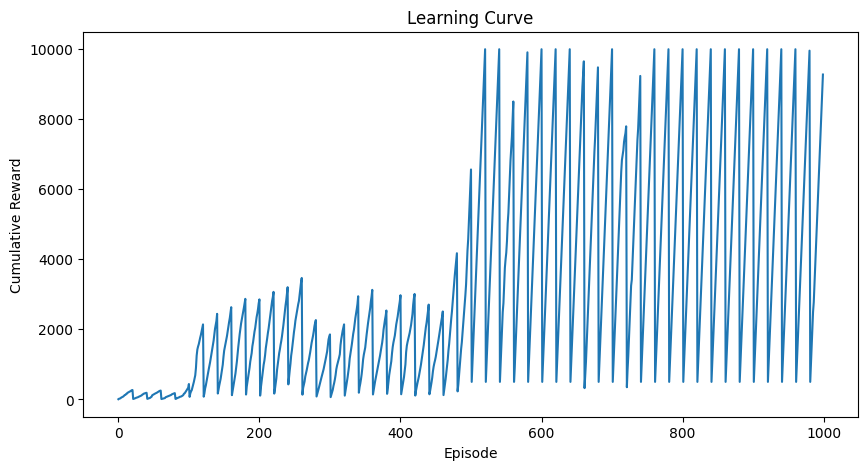

In [29]:
if __name__ == '__main__':
    main()